# Financial Time Series forecasting using Wavelet Transformation and SVM

## Contents:
* [First part, using SVM + slide window using original time series](#first-part)
    * [Graphical data analysis](#1.2)
    * [SVM + Sliding Window implementation](#1.3)
* [Second part, breaking the time series down into pieces using MODWT](#second-part)

***
### Description

This is a project based on the article named  "*SVR-Wavelet Adaptive Model for Forecasting Financial Time Series*" found here: https://ieeexplore.ieee.org/document/8356851. 

The data used is the historical currency values for AUD(Australian Dollar) to JPY (Japanese Yen) from: https://www.histdata.com/download-free-forex-historical-data/?/ascii/tick-data-quotes/AUDJPY in the period of 2003-2014, we had to transform the data from 1-minute interval to 1-day interval.

### Metodology

**First**, we evaluate the time series using the SVM without breaking it down into pieces.

**Second**, we break down in pieces the original time series using the maximal overlap discrete wavelet transform(MODWT) with 5 levels, obtaining the approximation coefficients (aC) and the detail coefficients (dC).

**Third**, we take the aC and each level of the dC and we evaluate them using the SVM algorithm using the Radial Basis Function Kernel (rbf). Then, we use the inverse MODWT (imodwt) to reconstruct the time series with the new coefficients from the SVM function. 

**Finally**, we use the reconstructed time series to carry out a new prediction using, again, the SVM and a window function to re-combine the time series values.
***

In [42]:
#Standard libraries
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
#Libraries for SVM implementation
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import mean_squared_error
from numpy.lib.stride_tricks import sliding_window_view
#Library for Wavelets transformations, the code was taken from: https://github.com/pistonly/modwtpy/blob/master/modwt.py
from lib.modwt import modwt, modwtmra,imodwt

## First part, using SVM + slide window using original time series <a class="anchor" id="first-part"></a>
***

### Graphical data analysis <a class="anchor" id="1.2"></a>

In [17]:
#Reading the data from csv file
#We use 'parse_dates' to convert the date string into objects we can work with
prices = pd.read_csv('../Data/AUD-JPY-2003-2014-day.csv',delimiter=";", header=0, encoding='utf-8', parse_dates=['Date'])
prices

,Date,Open,High,Low,Close
0,2003-01-01,67.05,67.06,67.05,67.06
1,2003-01-02,67.50,67.50,67.49,67.50
2,2003-01-03,67.98,67.98,67.98,67.98
3,2003-01-05,67.91,67.91,67.90,67.91
4,2003-01-06,68.69,68.69,68.68,68.68
...,...,...,...,...,...
3744,2014-12-26,97.71,97.71,97.68,97.70
3745,2014-12-28,97.82,97.82,97.80,97.80
3746,2014-12-29,97.92,97.93,97.88,97.88
3747,2014-12-30,98.02,98.02,98.01,98.02


In [18]:
# dropping unused columns 
prices.drop(["Open", "High", "Low"],axis = 1, inplace = True)
# defining variables
dates = prices['Date'].copy()
closing_prices = prices['Close'].copy()

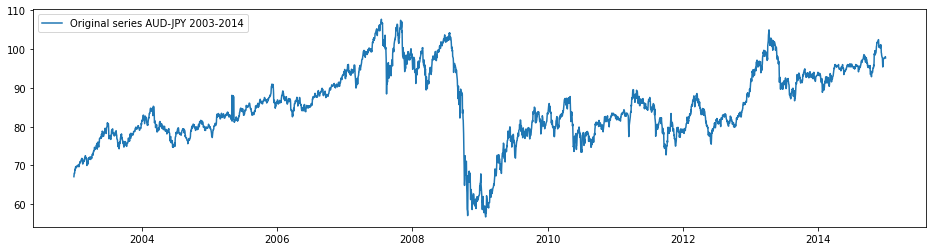

In [39]:
#Plotting the original time series using matplotlib. We are only plotting the 'Date' and 'Close' columns (2D)
plt.subplots(figsize=(16,4))
plt.plot(dates, closing_prices, label='Original series AUD-JPY 2003-2014')
#Legend location
plt.legend(loc = 'best')
plt.show()

### SVM + Sliding Window implementation <a class="anchor" id="1.3"></a>

Defining window lenght: how long back in time we see to predict the current value. E.g. If window_lenght=2, means that we take the two previous values to predict the value in current value. 
Let's say `closing_prices = [ 12, 13, 14 ]`, the sloding window determines that the value in `closing_prices[2] = [14]` is due to the values in `closing_prices[0:2] = [ 12, 13 ]`

In [26]:
#Implementing slide window
window_lenght = 2

X, Y = [], []
#Auxiliary variable to store the sliding window combinations. We sum up +1 as we are taking the last values of Aux_window
#as the output values of our time series
aux_Window =  sliding_window_view(closing_prices, window_lenght+1)
# Taking first 'window_lenght' values as the input (X) and the last value (window_lenght+1) as the output (Y)
for i in range(len(aux_Window)):
    Y.append(aux_Window[i][-1])
    X.append(aux_Window[i][:-1])

#We store the 'Dates' from the testing data on a separate variable to be able to plot it later
#We are taking the 25% of the dates as later, we take the 25% of the data to test the SVM
idx_test_date = int(0.75*len(Y)) + window_lenght
df = pd.DataFrame(columns = ['test_date']) 
df['test_date'] = prices['Date'].iloc[idx_test_date:]


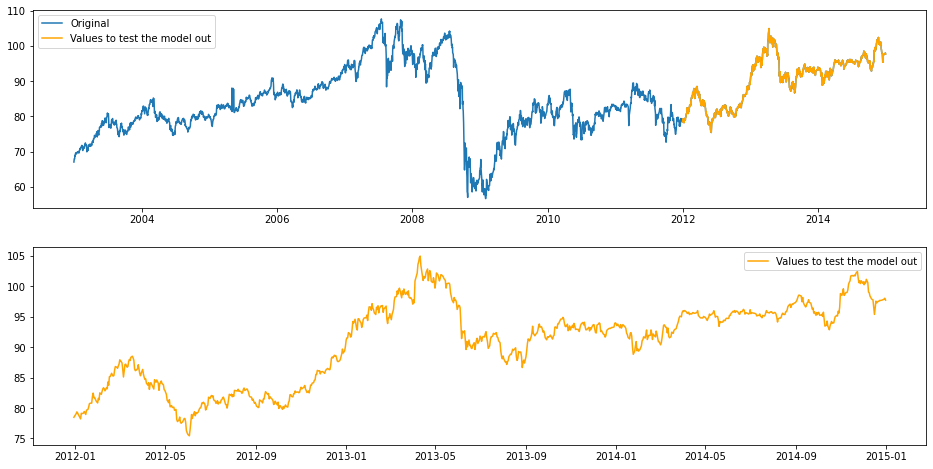

In [36]:
#Splitting and plotting test data

#First we split the data in training data(75%) and test data (25%)
#shuffle = False means that we are not shuffling the data randomly, we want to keep it in order
x_train,x_test,y_train,y_test = train_test_split(X, Y, test_size=0.25, random_state=None, shuffle=False)

#We can plot the data to make sure that we are taking the correct values to test out
fig, ax = plt.subplots(2,1,figsize=(16,8))
ax[0].plot(dates, closing_prices, label='Original')
ax[0].plot(df['test_date'], y_test, label='Values to test the model out',color='orange')
ax[1].plot(df['test_date'], y_test, label='Values to test the model out',color='orange')

ax[0].legend(loc = 'best')
ax[1].legend(loc = 'best')
plt.show()

The RMSE of rbf : 0.620997


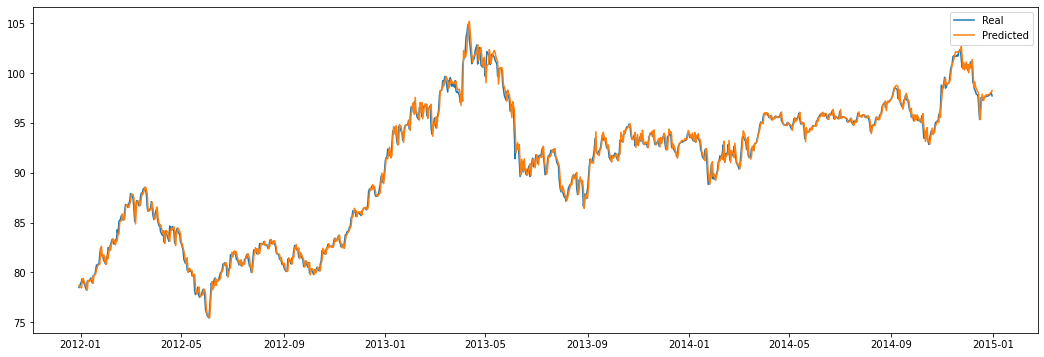

Performance:  0.9936530854141123


In [37]:
#Implementing SVR
#We can use multiple kernels to evaluate the model, for this implementation we only use 'rbf'
#This piece of code was taken from: https://github.com/hanazahrah/Forex-Prediction-using-SVR
#kernels = ['rbf', 'poly', 'linear']
kernels = ['rbf']

for kernel_arg in kernels: #,'poly','linear'
    if (kernel_arg == 'rbf'):
        clf = svm.SVR(kernel ='rbf', C=1e3, gamma=0.1)
    elif (kernel_arg == 'poly'):
        clf = svm.SVR(kernel ='poly', C=1e3, degree=2)
    else:
        clf = svm.SVR(kernel ='linear',C=1e3)
    y_predict = clf.fit(x_train,y_train).predict(x_test)
    print('The RMSE of %s : %f'%(kernel_arg, mean_squared_error(y_test, y_predict,squared=False)))
    #Plotting predicted values
    plt.subplots(figsize=(18, 6))
    plt.plot(df['test_date'], y_test, label = "Real")
    plt.plot(df['test_date'], y_predict, label = "Predicted")
    plt.legend(loc = 'best')
    plt.show()

    print("Performance: ",clf.score(x_train, y_train))


## Second part, breaking the time series down into pieces using MODWT <a class="anchor" id="second-part"></a>

(5, 3749)


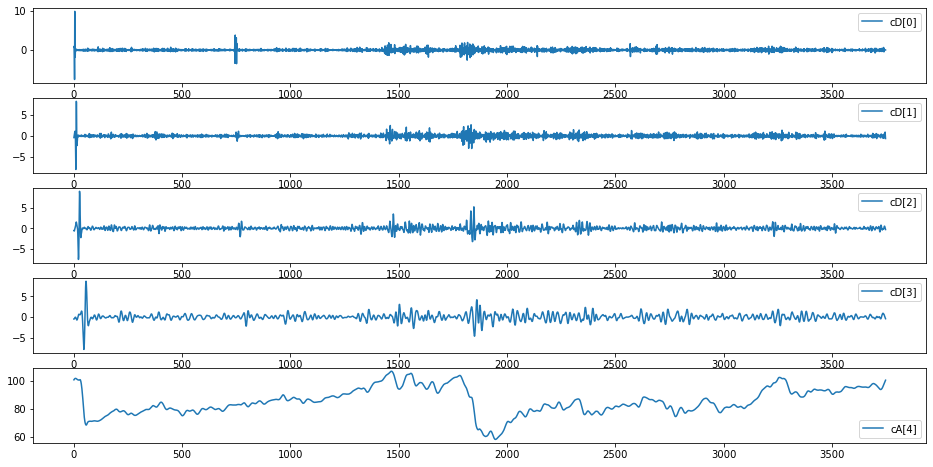

In [53]:
#Using modwt with 'sym4' wavelet and 5 levels (4 detail coffiecients (dC) and 1 approximation coefficient (aC))
def applyModwt(data):
    _coeff = modwt(data, 'sym4', 4)
    return _coeff

#calling function defined previously
coeff = applyModwt(closing_prices)

#Checking coeff shape, should be an array of len(closing_prices) columns and 5 rows
#where the row number 5  is the row with the approximation coefficients
print(np.shape(coeff))

#We can plot the dC and aC
fig, ax =  plt.subplots(len(coeff), 1, figsize=(16, 8))
for i in range(len(coeff)):
    if i == len(coeff)-1:
        ax[i].plot(coeff[i], label = 'cA[%.0f]'%(i))
        ax[i].legend(loc = 'best')
    else:
        ax[i].plot(coeff[i], label = 'cD[%.0f]'%(i))
        ax[i].legend(loc = 'best')

### Reconstructing original time series <a class="anchor" id="2.1"></a>